# Кластеризация bank

### Подготовка данных

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import os

In [3]:
# Устанавливаем рабочую дирректорию
os.chdir(r"C:\Users\whati\OneDrive\Рабочий стол\Jup\Projects_Analytics\clusters")

In [106]:
# Импорт данных
df = pd.read_csv("bank.csv", sep=";",  decimal=",") 
df['age'].mean()
df['balance'].mean()

1603.1683417085428

In [5]:
df.head()

,age,job,marital,education,default,balance,housing,loan,y
0,30,unemployed,married,primary,no,1787,no,no,no
1,33,services,married,secondary,no,4789,yes,yes,no
2,35,management,single,tertiary,no,1350,yes,no,no
3,30,management,married,tertiary,no,1476,yes,yes,no
4,59,blue-collar,married,secondary,no,0,yes,no,no


In [6]:
# Удаляем NA строки если такие есть
df = df.dropna() 

In [7]:
# Выводим сводную статистику по набору данных (только количественные признаки)
df.describe() 

,age,balance
count,398.000000,398.000000
mean,40.625628,1603.168342
std,10.290151,3006.880560
min,20.000000,-1680.000000
25%,33.000000,90.000000
50%,38.000000,462.000000
75%,48.000000,1789.250000
max,78.000000,26965.000000


array([[<AxesSubplot:xlabel='age', ylabel='age'>,
        <AxesSubplot:xlabel='balance', ylabel='age'>],
       [<AxesSubplot:xlabel='age', ylabel='balance'>,
        <AxesSubplot:xlabel='balance', ylabel='balance'>]], dtype=object)

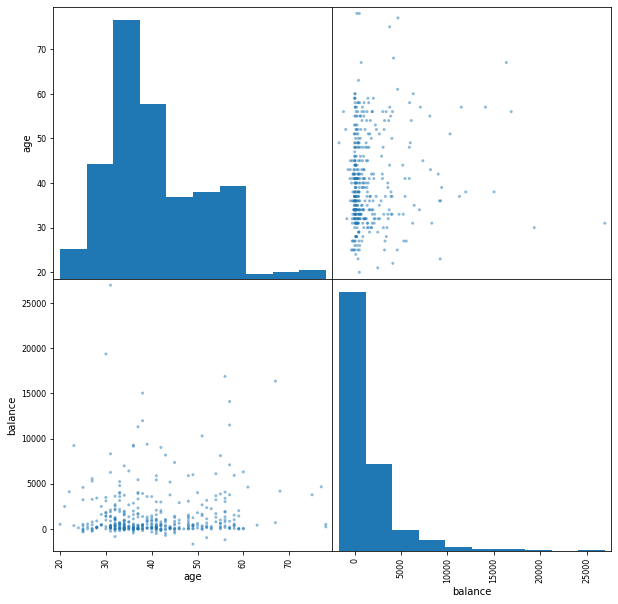

In [8]:
pd.plotting.scatter_matrix(df, figsize=(10, 10))

Из-за разности в диапазонах значений, очевидно, что нам необходимо стандартизировать количественные признаки

## Стандартизация

In [9]:
from sklearn import preprocessing

In [10]:
# Стандартизируем количественные признаки (В интервале 0,1)
scaler = preprocessing.MinMaxScaler() 
scaled_columns = scaler.fit_transform(df[['age', 'balance']])

In [11]:
# Создаем копию df
df_scaled = df.copy()

In [12]:
# Преобразуем стандартизированные колонки обратно в датафрейм
scaled_age_head = pd.DataFrame(scaled_columns, columns=['age', 'balance'])

In [13]:
scaled_age_head.head()

,age,balance
0,0.172414,0.121033
1,0.224138,0.225833
2,0.258621,0.105778
3,0.172414,0.110176
4,0.672414,0.058649


<AxesSubplot:>

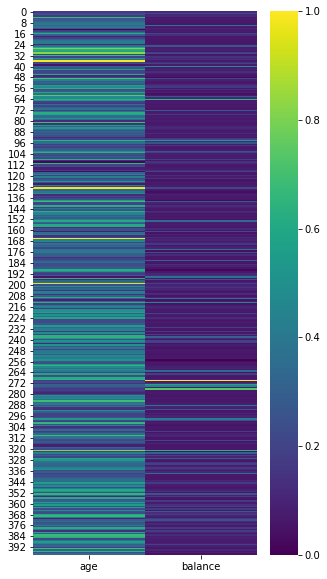

In [14]:
# Тепловая карта
fig_two = plt.figure(figsize=(5,10)) 
sns.heatmap(scaled_age_head, cmap = 'viridis')

In [15]:
df_scaled[['age','blance']] = scaled_age_head

In [16]:
df_scaled.head()

,age,job,marital,education,default,balance,housing,loan,y,blance
0,0.172414,unemployed,married,primary,no,1787,no,no,no,0.121033
1,0.224138,services,married,secondary,no,4789,yes,yes,no,0.225833
2,0.258621,management,single,tertiary,no,1350,yes,no,no,0.105778
3,0.172414,management,married,tertiary,no,1476,yes,yes,no,0.110176
4,0.672414,blue-collar,married,secondary,no,0,yes,no,no,0.058649


## Иерархическая кластеризация. (Метрика Гувера, метод дальнего соседа)

In [42]:
import gower
from scipy.cluster.hierarchy import dendrogram, linkage

In [43]:
# Вычисляем матрицу расстояний с использованием расстояния Гувера
dist_matrix = gower.gower_matrix(df_scaled)

In [44]:
# Применяем иерархическую кластеризацию
linked = linkage(dist_matrix, method='complete')

<ipython-input-44-48de937d1f0a>:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(dist_matrix, method='complete')


### Дендрограмма

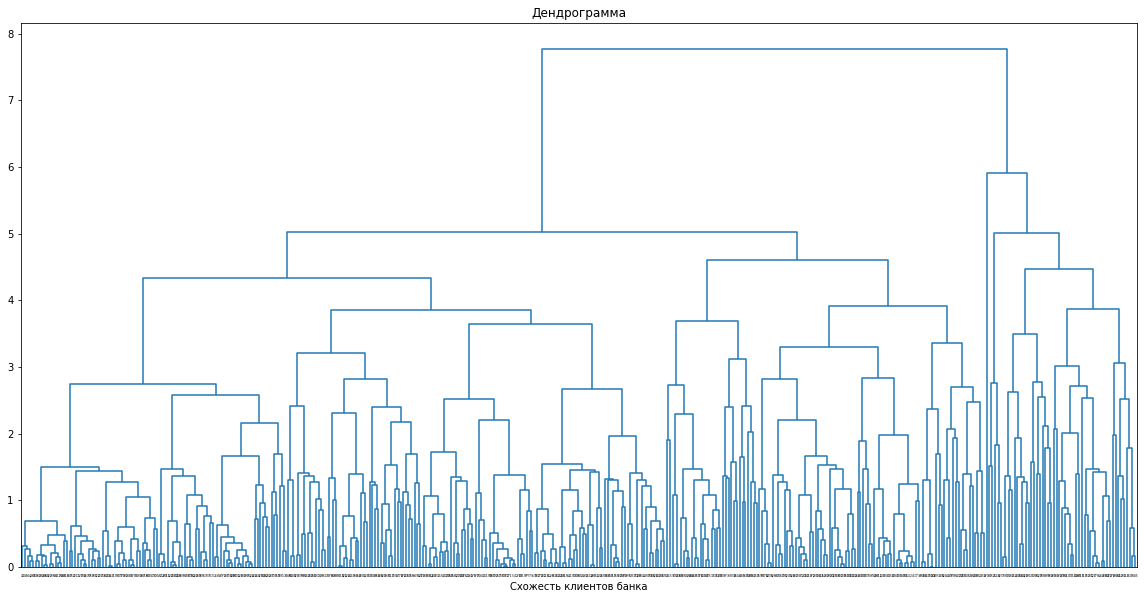

In [45]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Схожесть клиентов банка')
ax1.set_title('Дендрограмма')
dn = dendrogram(linked,
                leaf_font_size = 3,
                color_threshold= -1,
                orientation = "top",
                leaf_rotation= 0.)

Дендрограмма (8 кластеров)

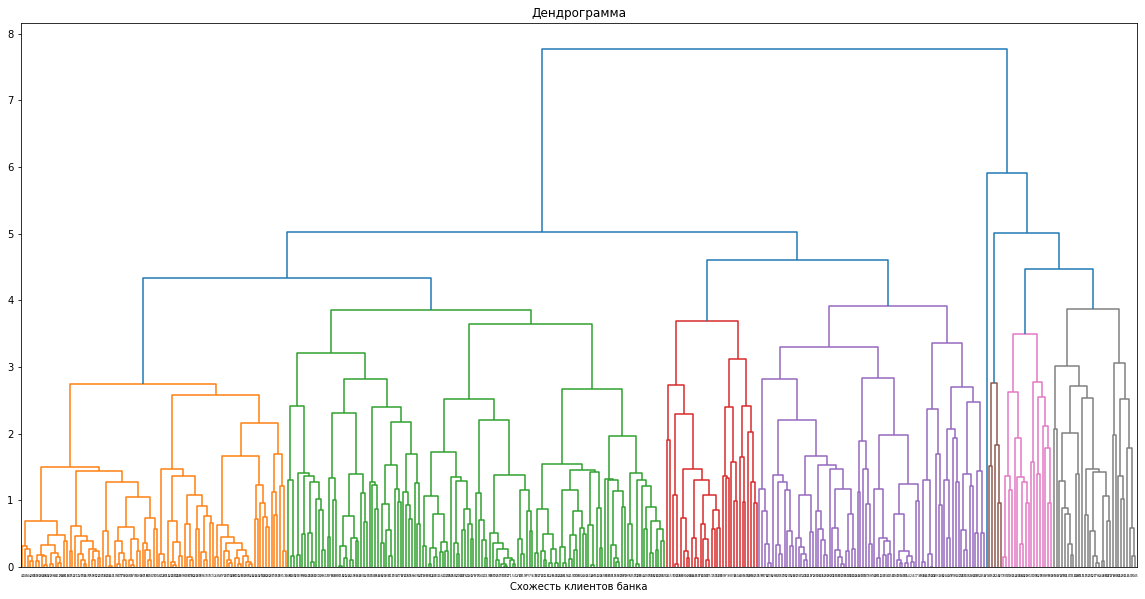

In [46]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Схожесть клиентов банка')
ax1.set_title('Дендрограмма')
dn = dendrogram(linked,
                leaf_font_size = 3,
                color_threshold= 4,
                orientation = "top",
                leaf_rotation= 0.)

### Каменистая осыпь

(0.0, 25.0)

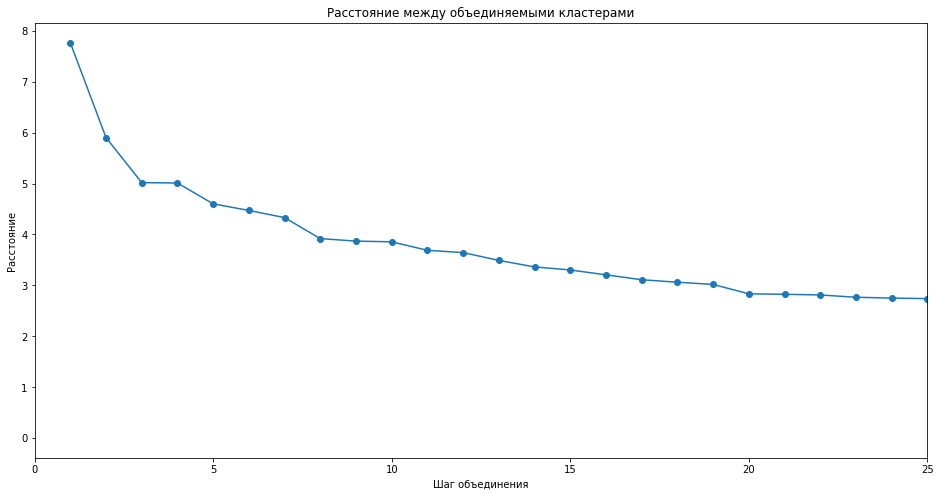

In [47]:
# Построение каменистой осыпи
fig = plt.figure(figsize=(16,8))
dist = linked[:, 2]
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.plot(idxs, dist_rev, marker='o')
plt.title('Расстояние между объединяемыми кластерами')
plt.xlabel('Шаг объединения')
plt.ylabel('Расстояние')
plt.xlim([0,25])

Видим что "локоть" образуется при количестве кластеров 3 и 8, возьмем 8 кластеров так как дальнейшее уменьшение расстояния незначительно 

In [48]:
df_clust = df.copy()

In [49]:
from scipy.cluster.hierarchy import fcluster

In [50]:
# Добавим информацию о номере кластера в таблицу
df_clust['cluster'] = fcluster(linked, 8, criterion='maxclust')

In [ ]:
# Средние значения кластеров
cluster_means = df_clust.groupby('cluster').mean()

In [51]:
# Список для хранения датафреймов с распределением категориальных переменных
cat_dfs = []

# Распределение категориальных переменных по кластерам
for column in df_clust.select_dtypes(include=[object]):  
    cat_distribution = pd.crosstab(index=df_clust['cluster'], columns=df_clust[column], normalize='index')
    
    # Переименовываем столбцы, чтобы сохранить информацию о переменной и ее уникальных значениях
    cat_distribution.columns = pd.MultiIndex.from_product([[column], cat_distribution.columns])
    
    # Добавляем датафрейм в список
    cat_dfs.append(cat_distribution)

# Объединяем все датафреймы в один
final_df = pd.concat([cluster_means] + cat_dfs, axis=1)

### Средние значения кластеров

In [244]:
pd.set_option('display.max_columns', None)
final_df

,age,balance,"(job, admin)","(job, blue-collar)","(job, entrepreneur)","(job, housemaid)","(job, management)","(job, retired)","(job, self-employed)","(job, services)","(job, student)","(job, technician)","(job, unemployed)","(job, unknown)","(marital, divorced)","(marital, married)","(marital, single)","(education, primary)","(education, secondary)","(education, tertiary)","(education, unknown)","(default, no)","(default, yes)","(housing, no)","(housing, yes)","(loan, no)","(loan, yes)","(y, no)","(y, yes)"
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,39.694737,984.694737,0.168421,0.326316,0.031579,0.010526,0.126316,0.031579,0.052632,0.063158,0.000000,0.168421,0.021053,0.000000,0.000000,1.000000,0.000000,0.210526,0.547368,0.210526,0.031579,1.000000,0.000000,0.0,1.0,1.000000,0.000000,1.000000,0.000000
2,43.074074,1832.555556,0.059259,0.177778,0.037037,0.037037,0.251852,0.051852,0.066667,0.066667,0.007407,0.192593,0.029630,0.022222,0.125926,0.651852,0.222222,0.170370,0.511111,0.296296,0.022222,1.000000,0.000000,1.0,0.0,0.896296,0.103704,0.970370,0.029630
3,43.303030,1516.848485,0.212121,0.272727,0.030303,0.000000,0.030303,0.060606,0.060606,0.151515,0.000000,0.181818,0.000000,0.000000,0.151515,0.787879,0.060606,0.151515,0.696970,0.000000,0.151515,0.939394,0.060606,0.0,1.0,0.393939,0.606061,0.727273,0.272727
4,36.876543,1665.382716,0.148148,0.160494,0.000000,0.012346,0.308642,0.024691,0.000000,0.086420,0.000000,0.259259,0.000000,0.000000,0.185185,0.098765,0.716049,0.061728,0.432099,0.456790,0.049383,0.987654,0.012346,0.0,1.0,0.839506,0.160494,0.901235,0.098765
5,44.800000,1002.000000,0.000000,0.000000,0.600000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.800000,0.000000,0.200000,0.400000,0.000000,0.600000,0.000000,0.400000,0.600000,0.0,1.0,0.200000,0.800000,1.000000,0.000000
6,46.833333,1793.277778,0.000000,0.166667,0.000000,0.000000,0.277778,0.222222,0.111111,0.000000,0.055556,0.055556,0.111111,0.000000,0.333333,0.333333,0.333333,0.222222,0.111111,0.611111,0.055556,1.000000,0.000000,1.0,0.0,1.000000,0.000000,0.000000,1.000000
7,35.633333,1597.133333,0.100000,0.133333,0.033333,0.000000,0.233333,0.000000,0.033333,0.066667,0.133333,0.266667,0.000000,0.000000,0.166667,0.133333,0.700000,0.000000,0.700000,0.300000,0.000000,0.900000,0.100000,1.0,0.0,0.366667,0.633333,0.766667,0.233333
8,31.000000,26965.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.0,1.000000,0.000000,0.000000,1.000000


In [53]:
# Кол-во наблюдений по кластерам
df_clust['cluster'].value_counts().sort_index()

1     95
2    135
3     33
4     81
5      5
6     18
7     30
8      1
Name: cluster, dtype: int64

## Интерпретация
### Кластер 1 (Бедные с семьей) 
* Средний возраст: 40, Средний баланс: 985.
* Преимущественно рабочие и технические специалисты.
* Все в браке.
* Образование высшее или среднее.
* Все без дефолта по кредитам.
* Все имеют жилье, и не брали кредит
* Всем отказано в кредите.

### Кластер 2 (Обеспеченные с семьей)
* Средний возраст: 43, Средний баланс: 1833.
* Преимущественно менеджеры и рабочие.
* Большинство женаты/замужем.
* Смешанное образование с акцентом на среднее и высшее.
* Все без дефолта по кредитам.
* Все не имеют жилья.
* Большинство не брало кредит.
* 97% отказано в кредите

### Кластер 3 (Брали кредит и вернули)
* Средний возраст: 43, Средний баланс: 1517.
* Администраторы и рабочие.
* В основном в браке.
* В основном среднее образование.
* Большинство без дефолта по кредитам.
* Все имеют жилье.
* Больше людей брало кредит.
* 72% отказано в кредите.

### Кластер 4 (Молодые одиночки)
* Средний возраст: 37, Средний баланс: 1665.
* Преимущественно менеджеры и технические специалисты.
* Большинство холосты.
* Среднее и высшее образование.
* Почти все без дефолта по кредитам.
* Все имеют жилье.
* Большинство не брало кредит.
* 90% отказано в кредите.

### Кластер 5 (Брали кредит и не вернули)
* Средний возраст: 45, Средний баланс: 1002.
* Предприниматели, пенсионеры и безработные
* В основном разведены.
* Смешанное образование с акцентом на высшее.
* Большинство имеют дефолт
* Все имеют жилье.
* Большинство уже брали кредиты.
* Всем отказано в кредите.

### Кластер 6 (Одобрили кредит)
* Средний возраст: 47, Средний баланс: 1793.
* Смешанные профессии
* Равномерное распределение семейного положения.
* Преимущественно высшее образование.
* Все без дефолта по кредитам.
* Все не имеют жилья.
* Все без текущих кредитов.
* Всем одобрили кредит.

### Кластер 7 (Молодые люди которые уже брали кредит и вернули)
* Средний возраст: 36, Средний баланс: 1597.
* Преимущественно менеджеры и технические специалисты.
* В основном одинокие.
* Преимущественно среднее образование.
* Большинство без дефолта по кредитам.
* Все имеют жилье.
* Большинство брали кредит
* 76% отказано в кредите

### Кластер 8 (Скорее всего выброс)

* возраст: 31, Баланс: 26965.
* Домрабоница.
* Одинокая
* Имеет начальное образование
* Нет дефолта по кредитам
* Есть дом
* Нет кредитов
* Кредит одобрен

Учитывая, что один из кластеров полностью состоит из людей которым выдали кредит, можно считать эту кластеризацию достаточно удачной

# K-means

### One-hot endcoding

In [216]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

In [217]:
categoricals = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'y']
df_category = df[categoricals]

In [218]:
encoder = OneHotEncoder(drop='first', sparse=False)
df_encoded = pd.DataFrame(encoder.fit_transform(df_category))
df_encoded.columns = encoder.get_feature_names(df_category.columns)

In [219]:
df_encoded[['age', 'balance']] = scaled_age_head[['age', 'balance']] 

In [220]:
df_encoded.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,y_yes,age,balance
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.172414,0.121033
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.224138,0.225833
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.258621,0.105778
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.172414,0.110176
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.672414,0.058649


<AxesSubplot:>

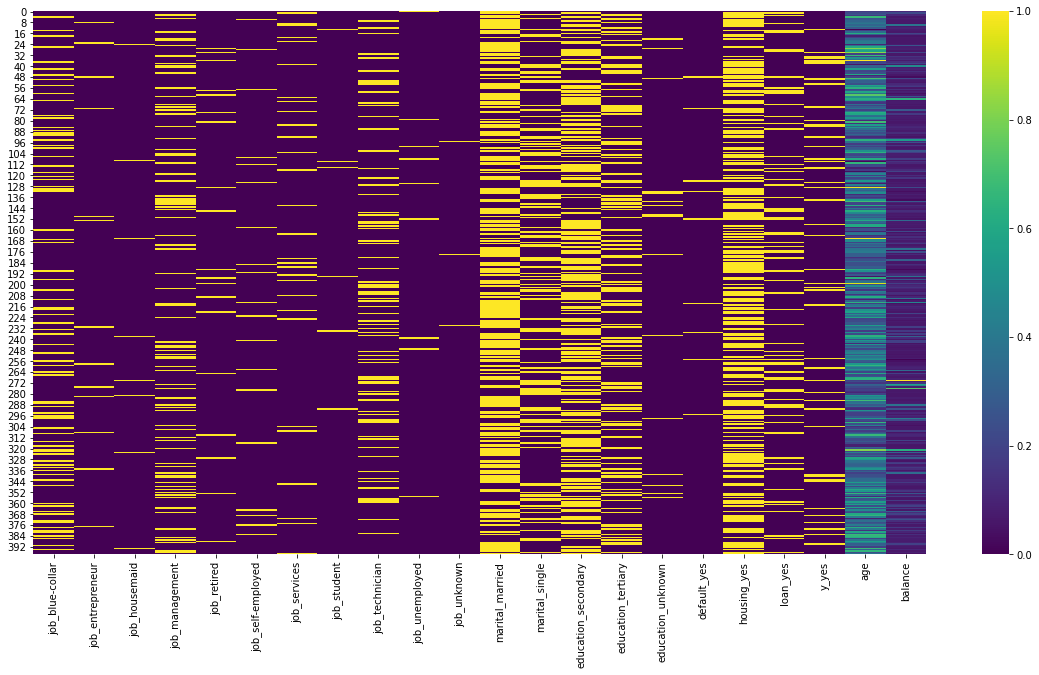

In [221]:
# Тепловая карта
fig_two = plt.figure(figsize=(20,10)) 
sns.heatmap(df_encoded, cmap = 'viridis')

C:\Users\whati\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


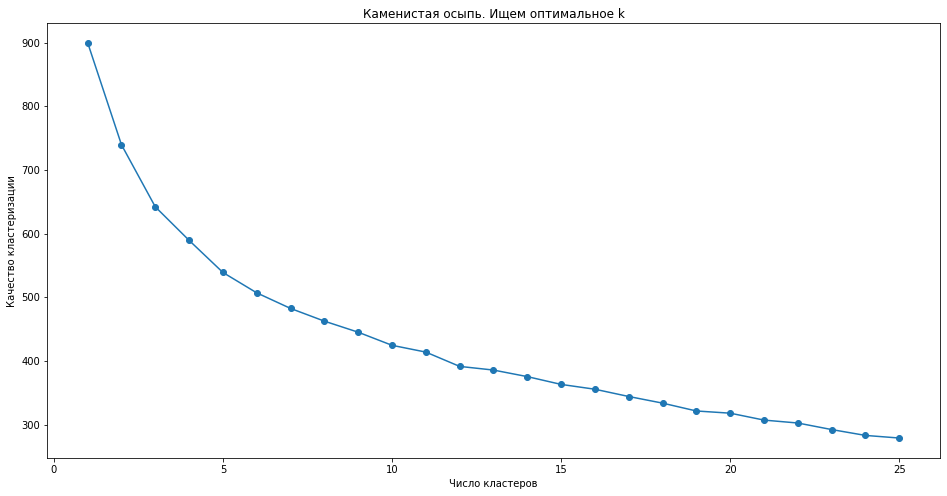

In [223]:
# Строим каменистую осыпь
K = range(1, 26)
models = [KMeans(n_clusters=k, random_state=42, n_init=100, verbose=0).fit(df_encoded) for k in K]

dist = [model.inertia_ for model in models]

fig_three = plt.figure(figsize=(16,8))
plt.plot(K, dist, marker='o')

plt.xlabel('Число кластеров')
plt.ylabel('Качество кластеризации')
plt.title('Каменистая осыпь. Ищем оптимальное k')
plt.show()

После 5 кластеров происходит незначительное сокращение межкластерного расстояния

In [237]:
km_clust = KMeans(n_clusters=5, random_state = 10, max_iter= 500, n_init=10, 
               verbose=0, tol=0.0001 )

In [238]:
cluster_labels = km_clust.fit_predict(df_encoded)

In [239]:
df_copy_2 = df_encoded.copy()

In [240]:
df_copy_2['cluster'] = cluster_labels

In [241]:
df_copy_2[['age', 'balance']] = df[['age', 'balance']].copy(deep=True)

In [242]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_copy_2.groupby('cluster').mean()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,y_yes,age,balance
cluster,,,,,,,,,,,,,,,,,,,,,,
0,0.200000,0.014286,0.014286,0.028571,0.014286,0.042857,0.157143,0.071429,0.242857,0.057143,0.000000,0.000000,1.000000,0.885714,0.000000,0.028571,0.028571,0.500000,0.242857,0.157143,33.371429,1702.628571
1,0.000000,0.028571,0.009524,0.104762,0.076190,0.047619,0.133333,0.000000,0.342857,0.009524,0.009524,0.847619,0.000000,1.000000,0.000000,0.000000,0.019048,0.533333,0.209524,0.076190,43.361905,1462.485714
2,0.010417,0.093750,0.062500,0.354167,0.104167,0.093750,0.031250,0.000000,0.114583,0.041667,0.010417,0.843750,0.000000,0.000000,0.635417,0.114583,0.031250,0.520833,0.125000,0.156250,44.937500,1648.302083
3,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.838235,0.000000,0.514706,0.000000,0.044118,0.014706,0.647059,0.161765,0.058824,42.000000,1398.264706
4,0.016949,0.000000,0.000000,0.627119,0.000000,0.033898,0.016949,0.016949,0.237288,0.000000,0.016949,0.000000,0.830508,0.000000,1.000000,0.000000,0.016949,0.491525,0.135593,0.152542,35.762712,1898.254237


In [243]:
# Кол-во наблюдений по кластерам
df_copy_2['cluster'].value_counts().sort_index()

0     70
1    105
2     96
3     68
4     59
Name: cluster, dtype: int64

## Интерпретация
### Кластер 1 (Молодые люди с приличным балансом)
* Средний возраст: 33, Средний баланс: 1700.
* Профессии: Технические специалисты, работники сферы услуг, и рабочие.
* Семейное положение: Все одиноки.
* Образование: Преимущественно среднее.
* Дефолт: Небольшой процент (3%) имели дефолт.
* Недвижимость: У половины есть дом.
* Кредитная история: 24% брали кредиты.
* Одобренный кредит: 16% одобрили кредит.


### Кластер 2 (Технические специалисты с балансом ниже среднего)
* Средний возраст: 43, Средний баланс: 1462.
* Профессии: Технические специалисты.
* Семейное положение: В основном женаты/замужем.
* Образование: среднее.
* Дефолт: Небольшой процент (2%) имел дефолт.
* Недвижимость: 53% имеют дом.
* Кредитная история: 21% брали кредиты.
* Одобренный кредит: 8% одобрили кредит.


### Кластер 3 (Женатые люди со средним балансом)
* Средний возраст: 45, Средний баланс: 1648.
* Профессии: Менеджеры и технические специалисты.
* Семейное положение: Почти все женаты/замужем.
* Образование: Большинство имеют высшее образование.
* Дефолт: Некоторые (3%) имели дефолт.
* Недвижимость: 52% имеют дом.
* Кредитная история: 13% брали кредиты.
* Одобренный кредит: 16% одобрили кредит.


### Кластер 4 (Пролетарии)
* Средний возраст: 42, Средний баланс: 1398.
* Профессии: Рабочие.
* Семейное положение: В основном женаты/замужем.
* Образование: В основном среднее.
* Дефолт: Некоторые (1.5%) имели дефолт.
* Недвижимость: Большинство (65%) имеют дом.
* Кредитная история: 16% брали кредиты.
* Одобренный кредит: 6% одобрилии кредит.


### Кластер 5 (Молодые Успешные Профессионалы)
* Средний возраст: 35, Средний баланс: 1898.
* Профессии: Менеджеры и технические специалисты.
* Семейное положение: Все одиночки.
* Образование: Все высшее.
* Дефолт: Некоторые (2%) имели дефолт.
* Недвижимость: Почти половина (49%) имеет дом.
* Кредитная история: 14% брали кредиты.
* Одобренный кредит: 15% одобрили кредит.

Качество кластеризации хуже, чем в иерархической кластеризации